In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpplot as gpp
import csv, warnings, math
from scipy.stats import ttest_ind
from scipy.interpolate import CubicSpline
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from adjustText import adjust_text
from poola import core as pool
import anchors

import core_functions as fns

gpp.set_aesthetics(palette='Set2')

In [5]:
import anchors
import statsmodels
from scipy import stats

def run_guide_residuals(lfc_df, paired_lfc_cols=[]):
    '''
    Calls get_guide_residuals function from anchors package to calculate guide-level residual z-scores
    Inputs:
    1. lfc_df: data frame with log-fold changes (relative to pDNA)
    2. paired_lfc_cols: grouped list of initial populations and corresponding resistant populations 
    
    '''
    lfc_df = lfc_df.drop_duplicates()
    if not paired_lfc_cols:
        paired_lfc_cols = fns.pair_cols(lfc_df)[1] #get lfc pairs 
    modified = []
    unperturbed = []
    #reference_df: column1 = modifier condition, column2 = unperturbed column
    ref_df = pd.DataFrame(columns=['modified', 'unperturbed'])
    row = 0 #row index for reference df 
    for pair in paired_lfc_cols:
        #number of resistant pops in pair = len(pair)-1
        res_idx = 1 
        #if multiple resistant populations, iterate 
        while res_idx < len(pair): 
            ref_df.loc[row, 'modified'] = pair[res_idx]
            ref_df.loc[row, 'unperturbed'] = pair[0]
            res_idx +=1 
            row +=1
    
    print(ref_df)
    #input lfc_df, reference_df 
    #guide-level
    residuals_lfcs, all_model_info, model_fit_plots = anchors.get_guide_residuals(lfc_df, ref_df)
    return residuals_lfcs, all_model_info, model_fit_plots


## Data summary
 

In [7]:
# Reads from GEO Submission GSE175666 
reads = pd.read_excel('Data/GSE175666_Supplementary_Data_1_VeroE6_KO_Goujon.xlsx', sheet_name = 'VeroE6_genomewide_reads')
reads


,Construct Barcode,pDNA,Vero E6 CRISPR population 1: CRISPR transduction efficiency 7%,"Vero E6 population 1 screen 1A (CoV-2 Resistant cells, infection 1, round 1 )","Vero E6 population 1 screen 1B (CoV-2 Resistant cells, round 2 - performed on 1A surviving cells)","Vero E6 population 1 screen 2 (CoV-2 Resistant cells, infection 2, started independently of 1A and 1B with lower cell density)",Vero E6 CRISPR population 2: CRISPR transduction efficiency 50%,"Vero E6 population 2 screen 1 (CoV-2 Resistant cells, ""infection 3"")"
0,TGATAGTAGGATAATAGCGA,67,416,176,64,713,251,735
1,AGGGTTGTAGTAGTCCGTAA,48,467,2222,2478,273,314,120
2,GCCTTCTATGAGGTCGAAGG,66,550,58,12,15,538,511
3,GATGGTGTAGAGAGTAGTGG,84,751,574,622,244,879,685
4,CCCTCAACAACCTACTATCG,68,1436,1794,1326,1227,883,544
...,...,...,...,...,...,...,...,...
84958,ATGGTACGTCGCGAACGATG,64,731,1533,2276,565,864,918
84959,CGGCGCCAATCGACGTGTCG,44,624,223,66,9,403,167
84960,GCCTCGACCGTGCGACGATA,70,963,1121,1538,781,889,865
84961,GGCTTAACGCCGCGTACAAG,37,584,236,66,109,386,480


In [9]:
# Gene Annotations
chip = pd.read_excel('Data/GSE175666_Supplementary_Data_1_VeroE6_KO_Goujon.xlsx', sheet_name = 'VeroE6_guide_mapping')

# Merge annotations with reads
chip_reads = pd.merge(chip[['Construct Barcode', 'Gene Symbol']], reads, on = ['Construct Barcode'], how = 'right')
chip_reads


,Construct Barcode,Gene Symbol,pDNA,Vero E6 CRISPR population 1: CRISPR transduction efficiency 7%,"Vero E6 population 1 screen 1A (CoV-2 Resistant cells, infection 1, round 1 )","Vero E6 population 1 screen 1B (CoV-2 Resistant cells, round 2 - performed on 1A surviving cells)","Vero E6 population 1 screen 2 (CoV-2 Resistant cells, infection 2, started independently of 1A and 1B with lower cell density)",Vero E6 CRISPR population 2: CRISPR transduction efficiency 50%,"Vero E6 population 2 screen 1 (CoV-2 Resistant cells, ""infection 3"")"
0,TGATAGTAGGATAATAGCGA,ND1,67,416,176,64,713,251,735
1,AGGGTTGTAGTAGTCCGTAA,ND1,48,467,2222,2478,273,314,120
2,GCCTTCTATGAGGTCGAAGG,ND1,66,550,58,12,15,538,511
3,GATGGTGTAGAGAGTAGTGG,ND1,84,751,574,622,244,879,685
4,CCCTCAACAACCTACTATCG,ND2,68,1436,1794,1326,1227,883,544
...,...,...,...,...,...,...,...,...,...
88866,ATGGTACGTCGCGAACGATG,NO_SITE_169,64,731,1533,2276,565,864,918
88867,CGGCGCCAATCGACGTGTCG,NO_SITE_143,44,624,223,66,9,403,167
88868,GCCTCGACCGTGCGACGATA,NO_SITE_149,70,963,1121,1538,781,889,865
88869,GGCTTAACGCCGCGTACAAG,NO_SITE_161,37,584,236,66,109,386,480


In [10]:
#Calculate lognorm
cols = chip_reads.columns[2:].to_list() #reads columns = start at 3rd column
lognorms = fns.get_lognorm(chip_reads.dropna(), cols = cols)
lognorms

,Construct Barcode,Gene Symbol,pDNA_lognorm,Vero E6 CRISPR population 1: CRISPR transduction efficiency 7%_lognorm,"Vero E6 population 1 screen 1A (CoV-2 Resistant cells, infection 1, round 1 )_lognorm","Vero E6 population 1 screen 1B (CoV-2 Resistant cells, round 2 - performed on 1A surviving cells)_lognorm","Vero E6 population 1 screen 2 (CoV-2 Resistant cells, infection 2, started independently of 1A and 1B with lower cell density)_lognorm",Vero E6 CRISPR population 2: CRISPR transduction efficiency 50%_lognorm,"Vero E6 population 2 screen 1 (CoV-2 Resistant cells, ""infection 3"")_lognorm"
0,TGATAGTAGGATAATAGCGA,ND1,3.687789,3.249224,2.278093,1.257144,4.098087,2.829099,4.207700
1,AGGGTTGTAGTAGTCCGTAA,ND1,3.250310,3.399397,5.632584,5.776831,2.842846,3.110858,1.946160
2,GCCTTCTATGAGGTCGAAGG,ND1,3.667789,3.614624,1.181974,0.334187,0.421425,3.816437,3.717106
3,GATGGTGTAGAGAGTAGTGG,ND1,3.991180,4.032133,3.761013,3.859096,2.704530,4.484411,4.111748
4,CCCTCAACAACCTACTATCG,ND2,3.707515,4.924614,5.330826,4.897417,4.845520,4.490669,3.800719
...,...,...,...,...,...,...,...,...,...
88866,ATGGTACGTCGCGAACGATG,NO_SITE_169,3.626938,3.995602,5.110094,5.656489,3.784336,4.460697,4.512801
88867,CGGCGCCAATCGACGTGTCG,NO_SITE_143,3.138497,3.782703,2.555469,1.283131,0.267296,3.433513,2.313561
88868,GCCTCGACCGTGCGACGATA,NO_SITE_149,3.746177,4.371311,4.673794,5.104704,4.222154,4.500006,4.430874
88869,GGCTTAACGCCGCGTACAAG,NO_SITE_161,2.919185,3.694287,2.623630,1.283131,1.792944,3.377203,3.633884


## Quality Control
### Population Distributions

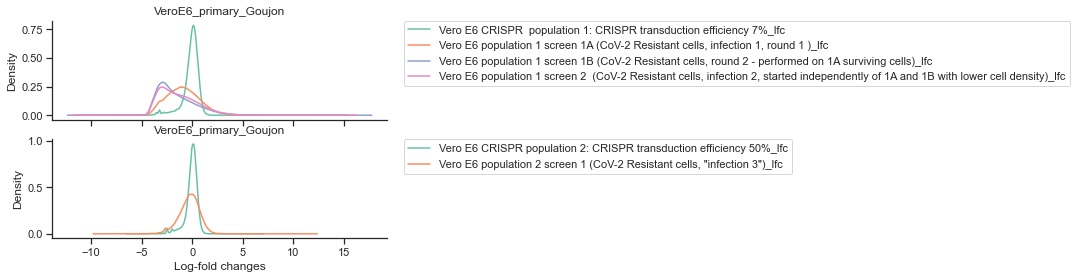

In [11]:
#Calculate log-fold change relative to pDNA
target_cols = list(lognorms.columns[3:])
pDNA_lfc = fns.calculate_lfc(lognorms,target_cols)

pop1_cols = [col for col in pDNA_lfc.columns if 'population 1' in col]
pop2_cols = [col for col in pDNA_lfc.columns if 'population 2' in col]

paired_cols = (True, [pop1_cols, pop2_cols])
#Plot population distributions of log-fold changes 
fns.lfc_dist_plot(pDNA_lfc, paired_cols=paired_cols, filename = 'VeroE6_primary_Goujon')



### Control Distributions

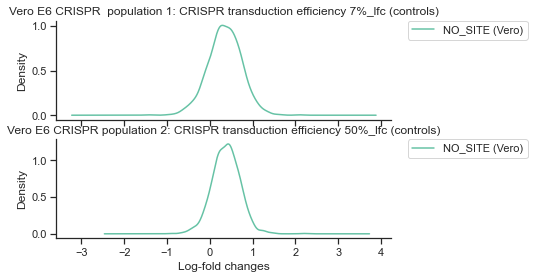

In [12]:
fns.control_dist_plot(pDNA_lfc, initial_id='CRISPR', res_id='resistant', control_name=['NO_SITE'], filename = 'VeroE6_primary_Goujon')



### ROC-AUC

Text(0, 0.5, 'True Positive Rate (essential)')

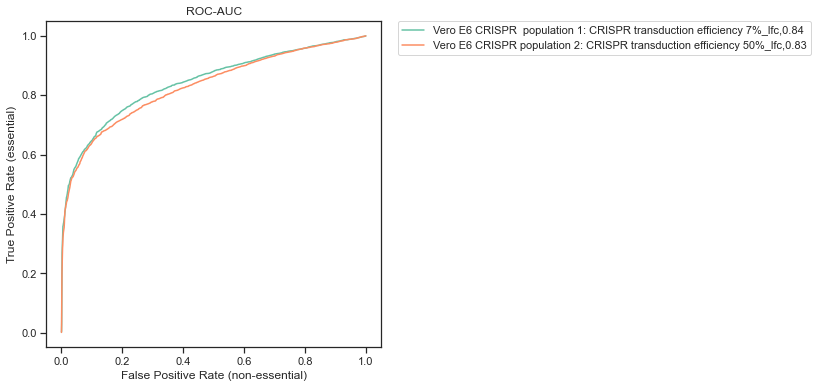

In [13]:
ess_genes, non_ess_genes = fns.get_gene_sets()
initial_cols = [col for col in pDNA_lfc.columns if 'CRISPR' in col]

tp_genes = ess_genes.loc[:, 'Gene Symbol'].to_list()

fp_genes = non_ess_genes.loc[:, 'Gene Symbol'].to_list()

initial_roc_dict = {}
intial_roc_auc_dict = {}
for col in initial_cols:
    roc_auc, roc_df = pool.get_roc_aucs(pDNA_lfc, tp_genes, fp_genes, gene_col = 'Gene Symbol', score_col=col)
    initial_roc_dict[col] = roc_df
    intial_roc_auc_dict[col] = roc_auc

fig,ax=plt.subplots(figsize=(6,6))

for key, df in initial_roc_dict.items():
    roc_auc = intial_roc_auc_dict[key]
    ax=sns.lineplot(data=df, x='fpr',y='tpr', ci=None, label = key+',' + str(round(roc_auc,2)))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('ROC-AUC')
plt.xlabel('False Positive Rate (non-essential)')
plt.ylabel('True Positive Rate (essential)')


## Gene-level analysis

### Residual z-scores

In [15]:
lfc_df = pDNA_lfc.drop('Gene Symbol', axis = 1)
lfc_df

,Construct Barcode,Vero E6 CRISPR population 1: CRISPR transduction efficiency 7%_lfc,"Vero E6 population 1 screen 1A (CoV-2 Resistant cells, infection 1, round 1 )_lfc","Vero E6 population 1 screen 1B (CoV-2 Resistant cells, round 2 - performed on 1A surviving cells)_lfc","Vero E6 population 1 screen 2 (CoV-2 Resistant cells, infection 2, started independently of 1A and 1B with lower cell density)_lfc",Vero E6 CRISPR population 2: CRISPR transduction efficiency 50%_lfc,"Vero E6 population 2 screen 1 (CoV-2 Resistant cells, ""infection 3"")_lfc"
0,TGATAGTAGGATAATAGCGA,-0.438565,-1.409696,-2.430645,0.410298,-0.858689,0.519911
1,AGGGTTGTAGTAGTCCGTAA,0.149087,2.382273,2.526521,-0.407465,-0.139452,-1.304151
2,GCCTTCTATGAGGTCGAAGG,-0.053165,-2.485815,-3.333603,-3.246365,0.148648,0.049316
3,GATGGTGTAGAGAGTAGTGG,0.040953,-0.230167,-0.132084,-1.286650,0.493231,0.120568
4,CCCTCAACAACCTACTATCG,1.217099,1.623311,1.189902,1.138005,0.783154,0.093204
...,...,...,...,...,...,...,...
88866,ATGGTACGTCGCGAACGATG,0.368664,1.483156,2.029551,0.157398,0.833759,0.885863
88867,CGGCGCCAATCGACGTGTCG,0.644206,-0.583028,-1.855366,-2.871201,0.295016,-0.824936
88868,GCCTCGACCGTGCGACGATA,0.625134,0.927617,1.358527,0.475977,0.753829,0.684697
88869,GGCTTAACGCCGCGTACAAG,0.775102,-0.295555,-1.636054,-1.126242,0.458018,0.714699


In [16]:
# run_guide_residuals(lfc_df.drop_duplicates(), cols)
residuals_lfcs, all_model_info, model_fit_plots = fns.run_guide_residuals(lfc_df, paired_cols=paired_cols[1])
residuals_lfcs


                                            modified  \
0  Vero E6 population 1 screen 1A (CoV-2 Resistan...   
1  Vero E6 population 1 screen 1B (CoV-2 Resistan...   
2  Vero E6 population 1 screen 2  (CoV-2 Resistan...   
3  Vero E6 population 2 screen 1 (CoV-2 Resistant...   

                                         unperturbed  
0  Vero E6 CRISPR  population 1: CRISPR transduct...  
1  Vero E6 CRISPR  population 1: CRISPR transduct...  
2  Vero E6 CRISPR  population 1: CRISPR transduct...  
3  Vero E6 CRISPR population 2: CRISPR transducti...  


,Construct Barcode,condition,residual,residual_z,unperturbed,lfc,lfc_reference
0,TGATAGTAGGATAATAGCGA,Vero E6 population 1 screen 1A (CoV-2 Resistan...,-0.083839,-0.061870,Vero E6 CRISPR population 1: CRISPR transduct...,-1.409696,-0.438565
1,TGATAGTAGGATAATAGCGA,Vero E6 population 1 screen 1B (CoV-2 Resistan...,-0.427047,-0.253697,Vero E6 CRISPR population 1: CRISPR transduct...,-2.430645,-0.438565
2,TGATAGTAGGATAATAGCGA,Vero E6 population 1 screen 2 (CoV-2 Resistan...,2.252560,1.350760,Vero E6 CRISPR population 1: CRISPR transduct...,0.410298,-0.438565
3,AGGGTTGTAGTAGTCCGTAA,Vero E6 population 1 screen 1A (CoV-2 Resistan...,2.993949,2.209404,Vero E6 CRISPR population 1: CRISPR transduct...,2.382273,0.149087
4,AGGGTTGTAGTAGTCCGTAA,Vero E6 population 1 screen 1B (CoV-2 Resistan...,3.883136,2.306863,Vero E6 CRISPR population 1: CRISPR transduct...,2.526521,0.149087
...,...,...,...,...,...,...,...
339847,ATGGTACGTCGCGAACGATG,Vero E6 population 2 screen 1 (CoV-2 Resistant...,0.410566,0.473911,Vero E6 CRISPR population 2: CRISPR transducti...,0.885863,0.833759
339848,CGGCGCCAATCGACGTGTCG,Vero E6 population 2 screen 1 (CoV-2 Resistant...,-0.833442,-0.962030,Vero E6 CRISPR population 2: CRISPR transducti...,-0.824936,0.295016
339849,GCCTCGACCGTGCGACGATA,Vero E6 population 2 screen 1 (CoV-2 Resistant...,0.283340,0.327055,Vero E6 CRISPR population 2: CRISPR transducti...,0.684697,0.753829
339850,GGCTTAACGCCGCGTACAAG,Vero E6 population 2 screen 1 (CoV-2 Resistant...,0.572949,0.661347,Vero E6 CRISPR population 2: CRISPR transducti...,0.714699,0.458018


In [22]:
guide_mapping = pool.group_pseudogenes(pDNA_lfc[['Construct Barcode', 'Gene Symbol']], pseudogene_size=4, gene_col='Gene Symbol', control_regex=['NO_SITE'])
guide_mapping

,Construct Barcode,Gene Symbol
0,TGATAGTAGGATAATAGCGA,ND1
1,AGGGTTGTAGTAGTCCGTAA,ND1
2,GCCTTCTATGAGGTCGAAGG,ND1
3,GATGGTGTAGAGAGTAGTGG,ND1
4,CCCTCAACAACCTACTATCG,ND2
...,...,...
88866,ATGGTACGTCGCGAACGATG,NO_SITE_171
88867,CGGCGCCAATCGACGTGTCG,NO_SITE_89
88868,GCCTCGACCGTGCGACGATA,NO_SITE_110
88869,GGCTTAACGCCGCGTACAAG,NO_SITE_198


In [23]:
gene_residuals = anchors.get_gene_residuals(residuals_lfcs.drop_duplicates(), guide_mapping)
gene_residuals

,condition,Gene Symbol,guides,avg_lfc,avg_lfc_reference,residual_zscore,p_value,fdr_bh
0,Vero E6 population 1 screen 1A (CoV-2 Resistan...,A1BG,4,0.159395,0.311078,0.845171,0.398016,0.994579
1,Vero E6 population 1 screen 1A (CoV-2 Resistan...,A1CF,4,-1.344175,-0.218573,-0.431911,0.665806,0.997340
2,Vero E6 population 1 screen 1A (CoV-2 Resistan...,A2ML1,4,-2.753590,-0.324162,-2.304046,0.021220,0.713183
3,Vero E6 population 1 screen 1A (CoV-2 Resistan...,A3GALT2,4,0.418067,0.421175,1.030075,0.302975,0.989515
4,Vero E6 population 1 screen 1A (CoV-2 Resistan...,A4GALT,4,-0.286043,0.357379,0.093495,0.925510,0.997340
...,...,...,...,...,...,...,...,...
90067,Vero E6 population 2 screen 1 (CoV-2 Resistant...,ZYG11A,4,-0.286366,-0.496226,0.888610,0.374213,0.981060
90068,Vero E6 population 2 screen 1 (CoV-2 Resistant...,ZYG11B,4,-0.629953,-0.081296,-0.739401,0.459663,0.981060
90069,Vero E6 population 2 screen 1 (CoV-2 Resistant...,ZYX,4,-0.727777,0.172043,-1.461692,0.143826,0.895153
90070,Vero E6 population 2 screen 1 (CoV-2 Resistant...,ZZEF1,4,-0.560207,-0.056428,-0.623809,0.532753,0.981906


In [24]:
gene_residual_sheet = fns.format_gene_residuals(gene_residuals, guide_min = 3, guide_max = 5)

guide_residual_sheet = pd.merge(guide_mapping, residuals_lfcs.drop_duplicates(), on = 'Construct Barcode', how = 'inner')
guide_residual_sheet

['Vero E6 population 1 screen 2  (CoV-2 Resistant cells, infection 2, started independently of 1A and 1B with lower cell density)_lfc', 'Vero E6 population 1 screen 1A (CoV-2 Resistant cells, infection 1, round 1 )_lfc', 'Vero E6 population 2 screen 1 (CoV-2 Resistant cells, "infection 3")_lfc', 'Vero E6 population 1 screen 1B (CoV-2 Resistant cells, round 2 - performed on 1A surviving cells)_lfc']
Vero E6 population 1 screen 2  (CoV-2 Resistant cells, infection 2, started independently of 1A and 1B with lower cell density)_lfc
Vero E6 population 1 screen 1A (CoV-2 Resistant cells, infection 1, round 1 )_lfc
Vero E6 population 2 screen 1 (CoV-2 Resistant cells, "infection 3")_lfc
Vero E6 population 1 screen 1B (CoV-2 Resistant cells, round 2 - performed on 1A surviving cells)_lfc


,Construct Barcode,Gene Symbol,condition,residual,residual_z,unperturbed,lfc,lfc_reference
0,TGATAGTAGGATAATAGCGA,ND1,Vero E6 population 1 screen 1A (CoV-2 Resistan...,-0.083839,-0.061870,Vero E6 CRISPR population 1: CRISPR transduct...,-1.409696,-0.438565
1,TGATAGTAGGATAATAGCGA,ND1,Vero E6 population 1 screen 1B (CoV-2 Resistan...,-0.427047,-0.253697,Vero E6 CRISPR population 1: CRISPR transduct...,-2.430645,-0.438565
2,TGATAGTAGGATAATAGCGA,ND1,Vero E6 population 1 screen 2 (CoV-2 Resistan...,2.252560,1.350760,Vero E6 CRISPR population 1: CRISPR transduct...,0.410298,-0.438565
3,TGATAGTAGGATAATAGCGA,ND1,Vero E6 population 2 screen 1 (CoV-2 Resistant...,1.513157,1.746616,Vero E6 CRISPR population 2: CRISPR transducti...,0.519911,-0.858689
4,AGGGTTGTAGTAGTCCGTAA,ND1,Vero E6 population 1 screen 1A (CoV-2 Resistan...,2.993949,2.209404,Vero E6 CRISPR population 1: CRISPR transduct...,2.382273,0.149087
...,...,...,...,...,...,...,...,...
355479,GGCTTAACGCCGCGTACAAG,NO_SITE_198,Vero E6 population 2 screen 1 (CoV-2 Resistant...,0.572949,0.661347,Vero E6 CRISPR population 2: CRISPR transducti...,0.714699,0.458018
355480,TAGCGAACACGATTACGCGT,NO_SITE_236,Vero E6 population 1 screen 1A (CoV-2 Resistan...,-1.162287,-0.857717,Vero E6 CRISPR population 1: CRISPR transduct...,-1.715113,0.194894
355481,TAGCGAACACGATTACGCGT,NO_SITE_236,Vero E6 population 1 screen 1B (CoV-2 Resistan...,-0.928498,-0.551595,Vero E6 CRISPR population 1: CRISPR transduct...,-2.230125,0.194894
355482,TAGCGAACACGATTACGCGT,NO_SITE_236,Vero E6 population 1 screen 2 (CoV-2 Resistan...,-1.713764,-1.027668,Vero E6 CRISPR population 1: CRISPR transduct...,-2.806858,0.194894
